In [157]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc

from src.trainer import Trainer
from keras.models import Model

In [2]:
proj_root = '/home/elijahc/projects/vae'
models_root = os.path.join(proj_root,'models')
dates = ['2019-01-{}'.format(n) for n in np.arange(10)+14]
paths = [os.path.join(models_root,d) for d in dates]
trans_amt = np.arange(10)/10
paths

['/home/elijahc/projects/vae/models/2019-01-14',
 '/home/elijahc/projects/vae/models/2019-01-15',
 '/home/elijahc/projects/vae/models/2019-01-16',
 '/home/elijahc/projects/vae/models/2019-01-17',
 '/home/elijahc/projects/vae/models/2019-01-18',
 '/home/elijahc/projects/vae/models/2019-01-19',
 '/home/elijahc/projects/vae/models/2019-01-20',
 '/home/elijahc/projects/vae/models/2019-01-21',
 '/home/elijahc/projects/vae/models/2019-01-22',
 '/home/elijahc/projects/vae/models/2019-01-23']

# Load Runs

In [190]:
class Run():
    def __init__(self,mapping=None):
        if mapping is not None:
            self.mapping = mapping
        else:
            self.mapping = {
                'input':'input_image',
                'y_class':'class',
                'z_lat': 'z_lat',
                'real': 'D',
            }
    
    def from_keras_model(self,keras_model,mapping=None):
        self.model = keras_model
        if mapping is not None:
            self.mapping = mapping
        else:
            mapping = self.mapping
            
        for attr_name,layer_name in mapping.items():
            if attr_name is 'input':
                setattr(self,attr_name,keras_model.input)
            else:
                setattr(self,attr_name,keras_model.get_layer(layer_name).output)

        self.E = Model(
            inputs=self.input,
            outputs=[self.y_class,self.z_lat,self.real],
            name='encoder'
        )

def run_from_dir(model_dir):
    run = Run()
    
    config = load_config(model_dir)

    # load json and create model
    with open(os.path.join(config.model_dir,'model.json'), 'r') as json_file:
        model_json = json_file.read()
        model = model_from_json(model_json)

        model.load_weights(os.path.join(config.model_dir,'weights.h5'))

    run.from_keras_model(model)
    run.config = config
        
    return run

In [193]:
runs = [run_from_dir(mod_dir) for mod_dir in paths]

loading... /home/elijahc/projects/vae/models/2019-01-14/params.json
loading... /home/elijahc/projects/vae/models/2019-01-15/params.json
loading... /home/elijahc/projects/vae/models/2019-01-16/params.json
loading... /home/elijahc/projects/vae/models/2019-01-17/params.json
loading... /home/elijahc/projects/vae/models/2019-01-18/params.json
loading... /home/elijahc/projects/vae/models/2019-01-19/params.json
loading... /home/elijahc/projects/vae/models/2019-01-20/params.json
loading... /home/elijahc/projects/vae/models/2019-01-21/params.json
loading... /home/elijahc/projects/vae/models/2019-01-22/params.json
loading... /home/elijahc/projects/vae/models/2019-01-23/params.json


# Load fve_dx and fve_dy data

In [24]:
fve_dx_norms = [np.nan_to_num(np.load(os.path.join(p,'fve_dx_norm.npy'))).mean(axis=0) for p in paths]
fve_dy_norms = [np.nan_to_num(np.load(os.path.join(p,'fve_dy_norm.npy'))).mean(axis=0) for p in paths]

In [61]:
dx_auc = [auc(np.arange(25)/25,f) for f in fve_dx_norms]
dy_auc = [auc(np.arange(25)/25,f) for f in fve_dy_norms]

dx_max = [f.max() for f in fve_dx_norms]
dy_max = [f.max() for f in fve_dy_norms]

## Make latent encoding generators

In [230]:
classifiers = [Model(t.E.input,t.y_class) for t in runs]
z_encoders = [Model(t.E.input,t.z_lat) for t in runs]

classifier_acc = []
z_encodings = []

for r,classifier,z_encoder,translation in zip(runs,classifiers,z_encoders,trans_amt):
    config = r.config
    if translation == 0:
        tx=None
    else:
        tx = translation
    
    DL = Shifted_Data_Loader(dataset=config.dataset,flatten=True,
                         rotation=None,
                         translation=tx,
                        )
    r.DL = DL
    
    classifier.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    _,acc = classifier.evaluate(DL.sx_test,DL.y_test_oh,batch_size=config.batch_size)
    classifier_acc.append(acc)
    
    z_enc = z_encoder.predict(DL.sx_test,batch_size=config.batch_size)
    z_encodings.append(z_enc)
#     y_lat = classifier.predict(DL.sx_test,batch_size=config.batch_size)
    

input_shape:  (3136,)
dataset:  fashion_mnist
scale:  2
tx_max:  None
rot_max:  None
loading fashion_mnist...
sx_train:  (60000, 3136)
making training data...
making testing data...
10000/10000 [==============================] - 3s 284us/step
input_shape:  (3136,)
dataset:  fashion_mnist
scale:  2
tx_max:  0.1
rot_max:  None
loading fashion_mnist...
sx_train:  (60000, 3136)
making training data...
making testing data...
10000/10000 [==============================] - 3s 270us/step
input_shape:  (3136,)
dataset:  fashion_mnist
scale:  2
tx_max:  0.2
rot_max:  None
loading fashion_mnist...
sx_train:  (60000, 3136)
making training data...
making testing data...
10000/10000 [==============================] - 3s 272us/step
input_shape:  (3136,)
dataset:  fashion_mnist
scale:  2
tx_max:  0.3
rot_max:  None
loading fashion_mnist...
sx_train:  (60000, 3136)
making training data...
making testing data...
10000/10000 [==============================] - 3s 296us/step
input_shape:  (3136,)
dataset: 

## Compute variance explained of isomap embeddings

In [434]:
from src.metrics import var_expl,norm_var_expl
from sklearn.preprocessing import MinMaxScaler


fa_10_iso_df = pd.read_pickle('../data/style_embeddings/fashion_mnist_isomap_10_neighbor.pk').set_index('test_idx').sort_index()

isos = fa_10_iso_df.isomap_dim_1.values
sub_dfs = []
for cid in np.arange(10):
    c_idxs = fa_10_iso_df.class_id.values==cid
    subset_df = fa_10_iso_df[c_idxs]
    scaler = MinMaxScaler(feature_range=(-14,14))
    sc_isos = scaler.fit_transform(isos[c_idxs].reshape(-1,1)).flatten()
    subset_df['scaled_isomap_dim_1'] = sc_isos
    sub_dfs.append(subset_df)

fa_10_iso_df = pd.concat(sub_dfs,axis=0).sort_index()
z_enc = z_encodings[3]
# fve_iso = var_expl(features=z_enc,cond=dxs,bins=21)


/home/elijahc/.pyenv/versions/jupyterlab-gpu/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [441]:
fa_10_iso_df.head()

,class_id,isomap_dim_1,scaled_isomap_dim_1
test_idx,,,
0,9,2501.723983,7.665259
1,2,2509.234302,6.727526
2,1,227.763048,4.840256
3,1,764.240528,6.231729
4,6,-344.645871,-2.835388


In [377]:
fve_isos_norm = []
for z_enc in z_encodings:
    isos = fa_10_iso_df.scaled_isomap_dim_1.values
#     ve = np.nan_to_num(var_expl(features=z_enc,cond=isos,bins=21))
    ve_norm = norm_var_expl(z_enc,isos,bins=21)
    fve_isos_norm.append(ve_norm.mean(axis=0))

/home/elijahc/projects/vae/notebooks/src/metrics.py:21: RuntimeWarning: Degrees of freedom <= 0 for slice
  Z_cond_var[j,i] = cond[np.where(Z_bin_idx[:,i]==j)[0]].var()
/home/elijahc/.pyenv/versions/jupyterlab-gpu/lib/python3.5/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/elijahc/.pyenv/versions/jupyterlab-gpu/lib/python3.5/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [443]:
fve_dx_norms = []
fve_dy_norms = []

z_dfs = []
for r,z_enc in zip(runs,z_encodings):
    dxs = r.DL.dx[1]-14
    dys = r.DL.dy[1]-14
    
    print(z_enc.shape)
    fve_dx_norm = norm_var_expl(z_enc,dxs,bins=11).mean(axis=0)
    fve_dy_norm = norm_var_expl(z_enc,dys,bins=11).mean(axis=0)
    fve_dx_norms.append(fve_dx_norm)
    fve_dy_norms.append(fve_dy_norm)
    
    df = pd.DataFrame.from_records({'dx':dxs,'dy':dys,'z_enc':z_enc.tolist()})
    df = df.join(fa_10_iso_df,how='left')
    z_dfs.append(df)
    

(10000, 25)
(10000, 25)


/home/elijahc/projects/vae/notebooks/src/metrics.py:28: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num((cond.var()-fve)/np.nan_to_num(cond.var()))


(10000, 25)
(10000, 25)
(10000, 25)
(10000, 25)
(10000, 25)
(10000, 25)


/home/elijahc/projects/vae/notebooks/src/metrics.py:21: RuntimeWarning: Degrees of freedom <= 0 for slice
  Z_cond_var[j,i] = cond[np.where(Z_bin_idx[:,i]==j)[0]].var()
/home/elijahc/.pyenv/versions/jupyterlab-gpu/lib/python3.5/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/elijahc/.pyenv/versions/jupyterlab-gpu/lib/python3.5/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(10000, 25)
(10000, 25)


In [446]:
for df,tx in zip(z_dfs,trans_amt):
    df.to_pickle('../data/style_embeddings/merge_{}.pk'.format(tx))

In [406]:
dx_auc = [auc(np.arange(25)/25,f) for f in fve_dx_norms]
dy_auc = [auc(np.arange(25)/25,f) for f in fve_dy_norms]
iso_auc = [auc(np.arange(25)/25,f) for f in fve_isos_norm]

dx_max = [f.max() for f in fve_dx_norms]
dy_max = [f.max() for f in fve_dy_norms]
isos_max = [f.max() for f in fve_isos_norm]

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

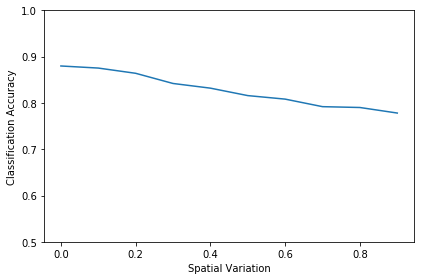

In [474]:
plt.plot(trans_amt,classifier_acc)
plt.ylim(0.5,1)
plt.ylabel('Classification Accuracy')
plt.xlabel('Spatial Variation')
plt.tight_layout()
plt.savefig('../figures/2019-01-28/acc_vs_spatial_variation.png')

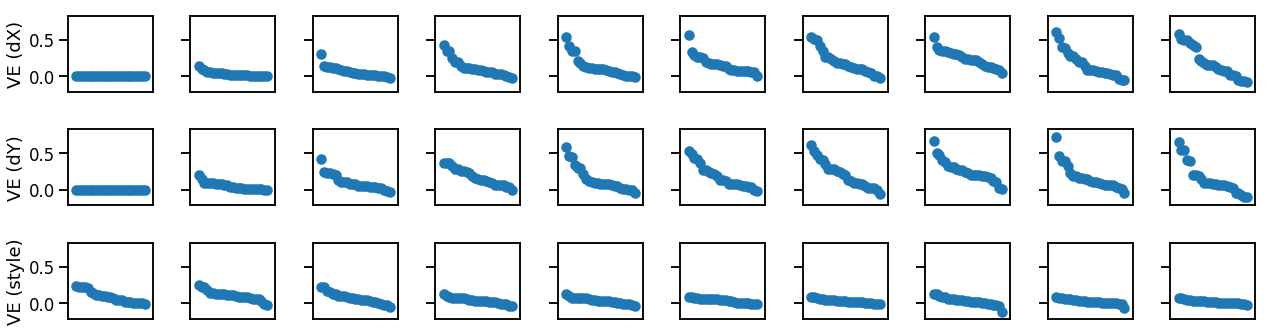

In [475]:
import seaborn as sns
sns.set_context('talk')
fig,axs = plt.subplots(3,10,sharex=True,sharey=True,figsize=(18,5))
# for ax in axs.flatten():
#     ax.set_ylim(0,1)
for fx,fy,fisos,i in zip(fve_dx_norms,fve_dy_norms,fve_isos_norm,np.arange(10)):
    axs[0,i].scatter(np.arange(25),sorted(fx,reverse=True))
    axs[1,i].scatter(np.arange(25),sorted(fy,reverse=True))
    axs[2,i].scatter(np.arange(25),sorted(fisos,reverse=True))
    

    axs[0,0].set_ylabel('VE (dX)')
    axs[1,0].set_ylabel('VE (dY)')
    axs[2,0].set_ylabel('VE (style)')
    
    for ax in axs[2]:
        ax.set_xticks([])
plt.tight_layout()
#     ax.set_yscale('log')
#     ax.set_ylim(0,1)
plt.savefig('../figures/2019-01-28/unit_fve_waterfall.png')

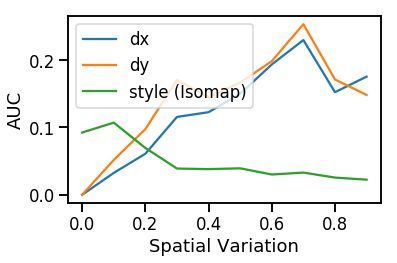

In [476]:
plt.plot(trans_amt,dx_auc)
plt.plot(trans_amt,dy_auc)
plt.plot(trans_amt,iso_auc)

plt.ylabel('AUC')
plt.xlabel('Spatial Variation')
plt.legend(['dx','dy','style (Isomap)'])
plt.tight_layout()
fig_filename = 'auc_vs_spatial_variation.png'
fig_fp = '../figures/2019-01-28/'+fig_filename
plt.savefig(fig_fp)
#     ax.set_yscale('log')
#     ax.set_ylim(0,1)

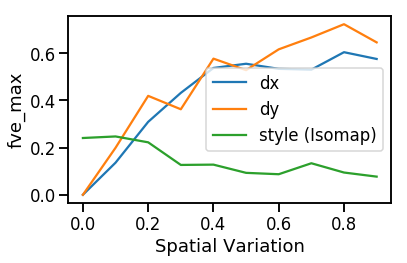

In [477]:
plt.plot(trans_amt,dx_max)
plt.plot(trans_amt,dy_max)
plt.plot(trans_amt,f_isos_max)
plt.ylabel('fve_max')
plt.xlabel('Spatial Variation')
plt.legend(['dx','dy','style (Isomap)'])
plt.tight_layout()
fig_filename = 'fve_max_vs_spatial_variation.png'
fig_fp = '../figures/2019-01-28/'+fig_filename
plt.savefig(fig_fp)

In [470]:
import seaborn as sns

sns.lineplot(trans_amt,y=)

In [128]:
from keras.models import model_from_json
# from src.config import load_config

def load_config(model_dir):
    fp = os.path.join(model_dir,'params.json')
    print('loading...',fp)
    with open(fp, 'r') as f:
        json_config = json.load(f)
        config = argparse.Namespace()
        for k in json_config.keys():
            setattr(config, k, json_config[k])
        return config



In [408]:
import scipy.stats as stats

In [433]:
dxs = runs[2].DL.dx[1]-14
hist_edges = np.histogram_bin_edges(dxs,bins=14)
bins,edges = np.histogram(dxs,bins=hist_edges,density=True)
stats.entropy(bins)

1.3862128207451367

In [425]:
rv = stats.rv_histogram((bins,edges))

2.0790084660941455